In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (필요시)
import matplotlib.font_manager as fm

# 나눔고딕 폰트 설정 (시스템에 설치되어 있다고 가정)
try:
    plt.rc('font', family='Malgun Gothic')
    plt.rcParams['axes.unicode_minus'] = False
except:
    print("맑은고딕 폰트가 설치되어 있지 않습니다. 기본 폰트를 사용합니다.")

In [2]:
# 1. 65세 이상 노인 인구 데이터 (2015-2024)
years_elderly = np.array(range(2015, 2025))
elderly_population = np.array([
    5832,
    5878,
    5963,
    6084,
    6118,
    6278,
    6310,
    6406,
    6486,
    6601
])

# 2. 경로당 개수 데이터
years_senior_center = np.array([2019, 2023, 2024])
senior_center_count = np.array([162, 182, 183])  # 해당 연도의 경로당 개수

1. 데이터 확인
노인 인구수 데이터: 10개 (2015-2024)
경로당 개수 데이터: 3개 (2017, 2023, 2024)

2. 2차 스플라인 보간법을 사용한 경로당 개수 데이터 확장
   Year  Elderly_Population  Senior_Center_Interpolated
0  2015                5832                         116
1  2016                5878                         130
2  2017                5963                         142
3  2018                6084                         153
4  2019                6118                         162
5  2020                6278                         169
6  2021                6310                         175
7  2022                6406                         179
8  2023                6486                         182
9  2024                6601                         183

3. LSTM 모델을 위한 데이터 전처리
노인 인구수 학습 데이터 형태: (5, 3)
경로당 개수 학습 데이터 형태: (5, 3, 2)

4. LSTM 모델 학습
노인 인구수 예측 모델 학습 중...
경로당 개수 예측 모델 학습 중...

5. 2023-2024년 예측 결과 및 실제값 비교
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
   Year  Actual_Elderly  Predicted_

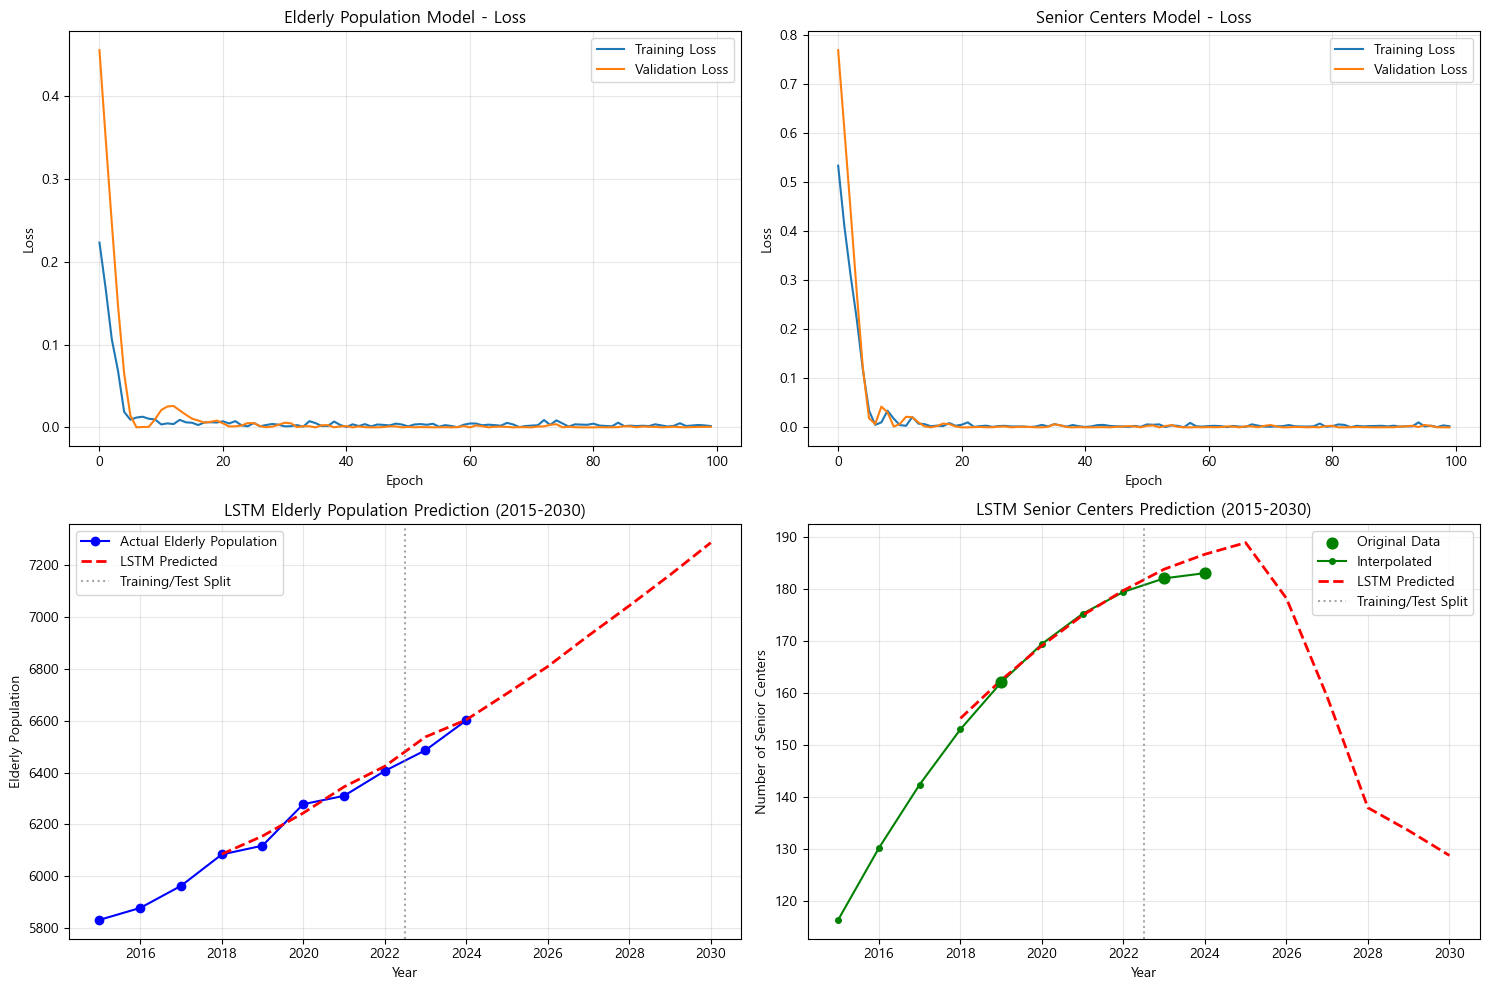


8. 노인 인구수와 경로당 개수의 관계 분석
노인 인구수와 경로당 개수의 상관계수: 0.9746


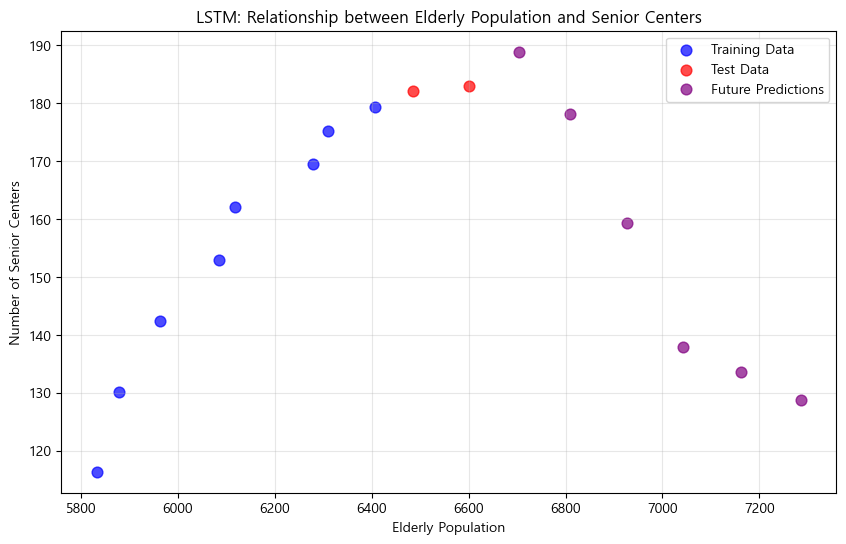


=== LSTM 분석 완료 ===


In [3]:
print("1. 데이터 확인")
print(f"노인 인구수 데이터: {len(elderly_population)}개 (2015-2024)")
print(f"경로당 개수 데이터: {len(senior_center_count)}개 (2017, 2023, 2024)")

# 2. 2차 스플라인 보간법을 사용하여 경로당 개수 데이터 확장
print("\n2. 2차 스플라인 보간법을 사용한 경로당 개수 데이터 확장")

# 2차 스플라인 보간 (k=2)
spline = UnivariateSpline(years_senior_center, senior_center_count, k=2, s=0)
senior_center_interpolated = spline(years_elderly)

# 보간 결과 출력
interpolation_df = pd.DataFrame({
    'Year': years_elderly,
    'Elderly_Population': elderly_population,
    'Senior_Center_Interpolated': np.round(senior_center_interpolated).astype(int)
})
print(interpolation_df)

# 3. LSTM 모델을 위한 데이터 전처리
print("\n3. LSTM 모델을 위한 데이터 전처리")

# 데이터 정규화
scaler_elderly = MinMaxScaler()
scaler_centers = MinMaxScaler()

elderly_scaled = scaler_elderly.fit_transform(elderly_population.reshape(-1, 1)).flatten()
centers_scaled = scaler_centers.fit_transform(senior_center_interpolated.reshape(-1, 1)).flatten()

# 시계열 데이터 생성 함수
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length)])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

# 시퀀스 길이 설정 (3년간의 데이터로 다음 해 예측)
sequence_length = 3

# 학습/테스트 데이터 분할 (2015-2022: 학습, 2023-2024: 테스트)
train_index = 8  # 2022년까지

# 노인 인구수 시퀀스 생성
X_elderly_full, y_elderly_full = create_sequences(elderly_scaled, sequence_length)
X_elderly_train = X_elderly_full[:train_index-sequence_length]
y_elderly_train = y_elderly_full[:train_index-sequence_length]
X_elderly_test = X_elderly_full[train_index-sequence_length:]
y_elderly_test = y_elderly_full[train_index-sequence_length:]

# 경로당 개수 시퀀스 생성 (노인 인구수 특성 포함)
combined_features = np.column_stack([elderly_scaled, centers_scaled])
X_centers_full, y_centers_full = [], []

for i in range(sequence_length, len(combined_features)):
    X_centers_full.append(combined_features[i-sequence_length:i])
    y_centers_full.append(centers_scaled[i])

X_centers_full = np.array(X_centers_full)
y_centers_full = np.array(y_centers_full)

X_centers_train = X_centers_full[:train_index-sequence_length]
y_centers_train = y_centers_full[:train_index-sequence_length]
X_centers_test = X_centers_full[train_index-sequence_length:]
y_centers_test = y_centers_full[train_index-sequence_length:]

print(f"노인 인구수 학습 데이터 형태: {X_elderly_train.shape}")
print(f"경로당 개수 학습 데이터 형태: {X_centers_train.shape}")

# 4. LSTM 모델 정의 및 학습
print("\n4. LSTM 모델 학습")

# 노인 인구수 예측 LSTM 모델
def create_elderly_lstm_model(sequence_length):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# 경로당 개수 예측 LSTM 모델 (다변량)
def create_centers_lstm_model(sequence_length, n_features):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(sequence_length, n_features)),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# 모델 생성 및 학습
print("노인 인구수 예측 모델 학습 중...")
model_elderly = create_elderly_lstm_model(sequence_length)
X_elderly_train_reshaped = X_elderly_train.reshape((X_elderly_train.shape[0], X_elderly_train.shape[1], 1))
history_elderly = model_elderly.fit(
    X_elderly_train_reshaped, y_elderly_train,
    epochs=100, batch_size=1, verbose=0, validation_split=0.2
)

print("경로당 개수 예측 모델 학습 중...")
model_centers = create_centers_lstm_model(sequence_length, 2)
history_centers = model_centers.fit(
    X_centers_train, y_centers_train,
    epochs=100, batch_size=1, verbose=0, validation_split=0.2
)

# 5. 2023-2024년 예측 및 실제값 비교
print("\n5. 2023-2024년 예측 결과 및 실제값 비교")

# 노인 인구수 예측
X_elderly_test_reshaped = X_elderly_test.reshape((X_elderly_test.shape[0], X_elderly_test.shape[1], 1))
pred_elderly_scaled = model_elderly.predict(X_elderly_test_reshaped)
pred_elderly_2023_2024 = scaler_elderly.inverse_transform(pred_elderly_scaled).flatten()

# 실제 테스트 데이터
actual_elderly_2023_2024 = elderly_population[-len(y_elderly_test):]

# 경로당 개수 예측 (실제 노인 인구수 사용)
pred_centers_scaled = model_centers.predict(X_centers_test)
pred_centers_2023_2024 = scaler_centers.inverse_transform(pred_centers_scaled.reshape(-1, 1)).flatten()

# 실제 테스트 데이터
actual_centers_2023_2024 = senior_center_interpolated[-len(y_centers_test):]

# 결과 비교
test_years = years_elderly[-len(y_elderly_test):]
comparison_df = pd.DataFrame({
    'Year': test_years,
    'Actual_Elderly': actual_elderly_2023_2024,
    'Predicted_Elderly': np.round(pred_elderly_2023_2024).astype(int),
    'Elderly_Error': np.abs(actual_elderly_2023_2024 - pred_elderly_2023_2024),
    'Actual_Centers': np.round(actual_centers_2023_2024).astype(int),
    'Predicted_Centers': np.round(pred_centers_2023_2024).astype(int),
    'Centers_Error': np.abs(actual_centers_2023_2024 - pred_centers_2023_2024)
})
print(comparison_df)

# 모델 성능 평가
print("\n=== LSTM 모델 성능 평가 ===")
print("노인 인구수 예측:")
print(f"  MAE: {mean_absolute_error(actual_elderly_2023_2024, pred_elderly_2023_2024):,.0f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(actual_elderly_2023_2024, pred_elderly_2023_2024)):,.0f}")
print(f"  R²: {r2_score(actual_elderly_2023_2024, pred_elderly_2023_2024):.4f}")

print("\n경로당 개수 예측:")
print(f"  MAE: {mean_absolute_error(actual_centers_2023_2024, pred_centers_2023_2024):.0f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(actual_centers_2023_2024, pred_centers_2023_2024)):.0f}")
print(f"  R²: {r2_score(actual_centers_2023_2024, pred_centers_2023_2024):.4f}")

# 6. 2025-2030년 미래 예측
print("\n6. 2025-2030년 미래 예측")

# 미래 예측을 위한 재귀적 방법
def predict_future_recursive(model, last_sequence, scaler, n_future_steps):
    predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(n_future_steps):
        # 다음 값 예측
        if len(current_sequence.shape) == 1:
            next_pred = model.predict(current_sequence.reshape(1, sequence_length, 1))
        else:
            next_pred = model.predict(current_sequence.reshape(1, sequence_length, current_sequence.shape[1]))
        
        # 예측값을 실제 스케일로 변환
        next_pred_original = scaler.inverse_transform(next_pred.reshape(-1, 1))[0, 0]
        predictions.append(next_pred_original)
        
        # 시퀀스 업데이트 (가장 오래된 값 제거, 새 예측값 추가)
        if len(current_sequence.shape) == 1:
            current_sequence = np.roll(current_sequence, -1)
            current_sequence[-1] = next_pred[0, 0]
        else:
            # 다변량의 경우, 노인 인구수와 경로당 수 모두 업데이트
            current_sequence = np.roll(current_sequence, -1, axis=0)
            # 새로운 노인 인구수로 스케일링
            elderly_scaled_new = scaler_elderly.transform([[next_pred_original]])[0, 0]
            current_sequence[-1, 0] = elderly_scaled_new
            current_sequence[-1, 1] = next_pred[0, 0]
    
    return np.array(predictions)

# 미래 예측 (2025-2030)
future_years = np.array([2025, 2026, 2027, 2028, 2029, 2030])
n_future_steps = len(future_years)

# 노인 인구수 미래 예측
last_elderly_sequence = elderly_scaled[-sequence_length:]
future_elderly_pred = predict_future_recursive(
    model_elderly, last_elderly_sequence, scaler_elderly, n_future_steps
)

# 경로당 개수 미래 예측
last_centers_sequence = combined_features[-sequence_length:]
future_centers_pred = predict_future_recursive(
    model_centers, last_centers_sequence, scaler_centers, n_future_steps
)

# 미래 예측 결과
future_df = pd.DataFrame({
    'Year': future_years,
    'Predicted_Elderly_Population': np.round(future_elderly_pred).astype(int),
    'Predicted_Senior_Centers': np.round(future_centers_pred).astype(int)
})
print(future_df)

# 7. 학습 과정 시각화
print("\n7. 학습 과정 시각화")
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 노인 인구수 모델 손실
ax1.plot(history_elderly.history['loss'], label='Training Loss')
ax1.plot(history_elderly.history['val_loss'], label='Validation Loss')
ax1.set_title('Elderly Population Model - Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 경로당 개수 모델 손실
ax2.plot(history_centers.history['loss'], label='Training Loss')
ax2.plot(history_centers.history['val_loss'], label='Validation Loss')
ax2.set_title('Senior Centers Model - Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 전체 예측 결과 시각화
all_years = np.concatenate([years_elderly, future_years])

# 노인 인구수 전체 예측 (학습 데이터 포함)
elderly_full_pred = []
for i in range(sequence_length, len(elderly_scaled)):
    seq = elderly_scaled[i-sequence_length:i].reshape(1, sequence_length, 1)
    pred = model_elderly.predict(seq, verbose=0)
    elderly_full_pred.append(scaler_elderly.inverse_transform(pred.reshape(-1, 1))[0, 0])

elderly_full_pred = np.array(elderly_full_pred)
all_elderly_pred = np.concatenate([
    [np.nan] * sequence_length,
    elderly_full_pred,
    future_elderly_pred
])

# 노인 인구수 그래프
ax3.plot(years_elderly, elderly_population, 'bo-', label='Actual Elderly Population', markersize=6)
ax3.plot(all_years, all_elderly_pred, 'r--', label='LSTM Predicted', linewidth=2)
ax3.axvline(x=2022.5, color='gray', linestyle=':', alpha=0.7, label='Training/Test Split')
ax3.set_xlabel('Year')
ax3.set_ylabel('Elderly Population')
ax3.set_title('LSTM Elderly Population Prediction (2015-2030)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 경로당 개수 전체 예측
centers_full_pred = []
for i in range(sequence_length, len(combined_features)):
    seq = combined_features[i-sequence_length:i].reshape(1, sequence_length, 2)
    pred = model_centers.predict(seq, verbose=0)
    centers_full_pred.append(scaler_centers.inverse_transform(pred.reshape(-1, 1))[0, 0])

centers_full_pred = np.array(centers_full_pred)
all_centers_pred = np.concatenate([
    [np.nan] * sequence_length,
    centers_full_pred,
    future_centers_pred
])

# 경로당 개수 그래프
ax4.scatter(years_senior_center, senior_center_count, color='green', s=60, label='Original Data', zorder=5)
ax4.plot(years_elderly, senior_center_interpolated, 'go-', label='Interpolated', markersize=4)
ax4.plot(all_years, all_centers_pred, 'r--', label='LSTM Predicted', linewidth=2)
ax4.axvline(x=2022.5, color='gray', linestyle=':', alpha=0.7, label='Training/Test Split')
ax4.set_xlabel('Year')
ax4.set_ylabel('Number of Senior Centers')
ax4.set_title('LSTM Senior Centers Prediction (2015-2030)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 8. 관계 분석
print("\n8. 노인 인구수와 경로당 개수의 관계 분석")

# 상관계수 계산
correlation = np.corrcoef(elderly_population[:-2], senior_center_interpolated[:-2])[0, 1]
print(f"노인 인구수와 경로당 개수의 상관계수: {correlation:.4f}")

# 관계 시각화
plt.figure(figsize=(10, 6))
train_elderly_orig = elderly_population[:train_index]
train_centers_orig = senior_center_interpolated[:train_index]
test_elderly_orig = elderly_population[train_index:]
test_centers_orig = senior_center_interpolated[train_index:]

plt.scatter(train_elderly_orig, train_centers_orig, color='blue', alpha=0.7, s=60, label='Training Data')
plt.scatter(test_elderly_orig, test_centers_orig, color='red', alpha=0.7, s=60, label='Test Data')
plt.scatter(future_elderly_pred, future_centers_pred, color='purple', alpha=0.7, s=60, label='Future Predictions')

plt.xlabel('Elderly Population')
plt.ylabel('Number of Senior Centers')
plt.title('LSTM: Relationship between Elderly Population and Senior Centers')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n=== LSTM 분석 완료 ===")